# =============================================================================
## Outline:
You have been approached by the consumer lending department to help them automate their underwriting process. As part of the exercise, they have gathered loan-level performance data indicating whether or not a given credit defaulted. Propose a model-based solution for the department.

## Objectives: 
###### 1.How well should the department expect your model to identify defaults?
###### 2.How confident are you the model will work well in implementation (new data)?
###### 3.Briefly explain the effect of each variable in your final model on credit risk.
###### 4.Please provide the probabilities of default (probability of class = 1) in a csv file as a new column labeled PD.


# =============================================================================



#### -- Contact  : Piyush Chopra
#### -- Email      : piychopra@gmail.com
#### -- LinkedIn : https://www.linkedin.com/in/piychopra/

# Notebook Index
1. Import Libraries
2. Data cleaning
3. Multicollinearity and Variance Inflation Factor Checks.
4. Exploratory Data Analysis: Converting to categorical variables and Data Visualization
5. Model Building
6. Feature Selection
7. Test Results and Accuracy
8. Goodness of fit

## Import Libraries

In [1]:
## Import Python Libraries
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from pylab import rcParams

sb.set(style="white")
sb.set(style="whitegrid",color_codes=True)
pd.set_option('display.max_columns', 500)
%matplotlib inline

## Scikit Learn Packages
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
#Logistic Regression Model Fitting
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
### ROC Curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

import statsmodels.api as sm
from statsmodels.formula.api import logit


Import data from CSV file into a Pandas Dataframe for analysis

In [2]:
# =============================================================================
# Data
# =============================================================================

loan_application=pd.read_csv(r'/Users/PiyushChopra/Desktop/TCF Bank/interview-exercise/loan_application.csv',usecols = ['y','x1','x2','x3','x4','x5','x6'])

#Print the first 5 rows of the data
loan_application.head()



,y,x1,x2,x3,x4,x5,x6
0,1,0,2508,54,231,745,2
1,1,1,1854,61,504,746,79
2,1,0,3038,39,126,610,81
3,0,0,6889,25,719,693,68
4,1,1,5785,72,189,805,27


## Data Cleaning

Checking for Missing values (NAs and NANs) and removing them before the analysis.

In [3]:
# Check for Missing Values 
print(loan_application.info())
print("-----------------------------------")

print("Data Types \n",loan_application.dtypes)
print("-----------------------------------")

print("Any NA's \n",loan_application.isna().any())
print("-----------------------------------")

print("Total NA's \n",loan_application.isna().sum())
print("-----------------------------------")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 7 columns):
y     25000 non-null int64
x1    25000 non-null int64
x2    25000 non-null int64
x3    25000 non-null int64
x4    25000 non-null int64
x5    25000 non-null int64
x6    25000 non-null int64
dtypes: int64(7)
memory usage: 1.3 MB
None
-----------------------------------
Data Types 
 y     int64
x1    int64
x2    int64
x3    int64
x4    int64
x5    int64
x6    int64
dtype: object
-----------------------------------
Any NA's 
 y     False
x1    False
x2    False
x3    False
x4    False
x5    False
x6    False
dtype: bool
-----------------------------------
Total NA's 
 y     0
x1    0
x2    0
x3    0
x4    0
x5    0
x6    0
dtype: int64
-----------------------------------



The data has No missing values Across all features. 
 -- This is a good sign. Majority of our the task in data cleaning is eliminated.
 All of our data are numeric. The data looks good for Model Building. Many python libraries work with numeric data and hence its required to convert categorical inputs to numeric/dummy variables using either one-hot encoding or generating dummies.



## Multicollinearity and Variance Inflation Factor
Let's look at the summary of the data and some plots to understand the patterns in the data.

In [4]:
## Get a Summary of the Data Set.
print(loan_application.describe())

                 y            x1            x2           x3            x4  \
count  25000.00000  25000.000000  25000.000000  25000.00000  25000.000000   
mean       0.50008      0.495400   4760.323720     49.05284    472.786800   
std        0.50001      0.499989   2156.991931     18.01695    217.319245   
min        0.00000      0.000000   1000.000000     18.00000    100.000000   
25%        0.00000      0.000000   2886.000000     33.00000    284.000000   
50%        1.00000      0.000000   4776.000000     49.00000    471.000000   
75%        1.00000      1.000000   6621.000000     65.00000    663.000000   
max        1.00000      1.000000   8499.000000     80.00000    850.000000   

                 x5            x6  
count  25000.000000  25000.000000  
mean     674.515880     50.475720  
std      100.559481     28.570961  
min      500.000000      1.000000  
25%      588.000000     26.000000  
50%      675.000000     50.000000  
75%      761.000000     75.000000  
max      850.00000

Lets understand our data better. Below is a high level information on all the variables in our dataset.
1. Y  - Categorical - 2 levels - 0,1
2. X1 - Categorical - 2 levels - 0,1
3. X2 - Ranges from [1000,8499]
4. X3 - Ranges from [18,80] 
5. X4 - Ranges from [100,850]
6. X5 - Ranges from [500,850]
7. X6 - Ranges from [1,100]



**Potential Reasonings on feature vectors :**


Since its a loan-level performance data its safe to assume that "Age-group" and a persons "Credit Rating" are amongst some of the most useful choices to determine loan eligility and are intuitive variables to determine defaults.

From our dataset -- We can try to get some sense of the variables (just making a guess and is not inferring it from the data)
Looking at the range of Variable X3, it could be a person's age.
Variable X5 could be a person's credit score as it usually ranges between 500-850. 

To get a better sense of variables we can try to convert these into categorical inputs and see the distribution of defaults across various categories.

In [5]:
## First Lets make a copy of original Dataset
df1=loan_application.copy()

We can look at correlation histogram to understand the correlation between our output "Y" variable
and Predictors . This would also be useful to identify potential cases of possible **multicollinearity** between the predictors

<Figure size 1080x1080 with 0 Axes>

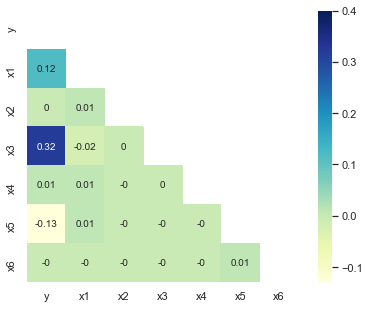

In [6]:
## We can look at correlation across variables to determine correlation between our output "Y" variable
## and Predictors and look for possible multicollinearity between the predictors
corr_df=df1.corr().round(2)
max_corr = 0.4
plt.figure(figsize=(15,15))
mask = np.zeros_like(corr_df)
mask[np.triu_indices_from(mask)] = True
with sb.axes_style("white"):
    f, ax = plt.subplots(figsize=(7, 5))
    ax = sb.heatmap(corr_df, mask=mask,vmax=max_corr, square=True, annot=True, cmap="YlGnBu")
 

From the correlation heatmap, we see that Variable X3 has some correlation with the Output "Y" variable. The other variables however seem to have poor correlation with Y.
Correlation within the Predictors are almost 0 hence we dont have to worry about potential multicollinearity issues. 


Lets Check for **Variance Inflation Factors** to see which variables can be well explained by other independant variables.
A higher VIF Score is problematic and the corresponding variable might need more attention while using it in the model, such as removing the variable or using trasformations.


In [7]:
def calculate_vif(input_df):
  Var_Inf_frame = pd.DataFrame()
  Var_Inf_frame["variables"] = input_df.columns
  Var_Inf_frame["VIF_Score"] = [variance_inflation_factor(input_df.values, i) for i in  range(input_df.shape[1])]
  return(Var_Inf_frame)

X1 = df1.drop(columns=["y","x1"])
calculate_vif(X1)
## From the VIF table, Variable X5 has very high VIF score and needs further attention going forward.

,variables,VIF_Score
0,x2,5.442342
1,x3,7.457182
2,x4,5.314744
3,x5,14.658673
4,x6,3.934864


From the VIF table, Variable X5 has very high VIF score and needs further attention while using it in our model. 

## Exploratory Data Analysis

Let's convert the numeric variables to categorical just for X3 and X5 and see how the distributions look for the whole data.

In [8]:
## Converting Variable X3 as Categories
X3_bins = [17,30,45,65,85]
X3_categories = ['1', '2', '3', '4']
df1['X3_Cat'] = pd.cut(df1['x3'], X3_bins, labels=X3_categories).astype(int)

## Converting Variable X5 as Categories
X5_bins = [450,600,700,800,np.inf]
X5_categories = ['1', '2', '3', '4']
df1['X5_Cat'] = pd.cut(df1['x5'], X5_bins, labels=X5_categories).astype(int)

df1

,y,x1,x2,x3,x4,x5,x6,X3_Cat,X5_Cat
0,1,0,2508,54,231,745,2,3,3
1,1,1,1854,61,504,746,79,3,3
2,1,0,3038,39,126,610,81,2,2
3,0,0,6889,25,719,693,68,1,2
4,1,1,5785,72,189,805,27,4,4
...,...,...,...,...,...,...,...,...,...
24995,0,1,7929,45,123,548,95,2,1
24996,0,0,5428,38,269,566,92,2,1
24997,0,1,3051,21,839,600,11,1,1
24998,0,0,2917,64,169,526,26,3,1


**Counts per category**

In [9]:
## Count of Data Points across Categorical variables - Y, X1, X3_Cat, X5_Cat

print("Y =",df1['y'].value_counts())
print("-----------------------------------")

print(df1['x1'].value_counts())
print("-----------------------------------")

print(df1['X3_Cat'].value_counts())
print("-----------------------------------")

print(df1['X5_Cat'].value_counts())
print("-----------------------------------")


Y = 1    12502
0    12498
Name: y, dtype: int64
-----------------------------------
0    12615
1    12385
Name: x1, dtype: int64
-----------------------------------
3    8072
4    5909
2    5894
1    5125
Name: X3_Cat, dtype: int64
-----------------------------------
3    7206
1    7183
2    7169
4    3442
Name: X5_Cat, dtype: int64
-----------------------------------


Output Variable "Y" and Predictor "X1" are balanced classes with similar obervations across both categories.
This is good as we do not have sparse data or have to deal with class imbalance. Often, working with class imbalance (More obersations in one category as opposed to others) have a Significant impact in pulling the results towards the class that is more frequent and thus leads to Bias in our results. 
In this case, we do not have to perform sampling adjustments to our dataset.


### **Vizualization: Barplots, Boxplots and Histogram**

### **Barplots**

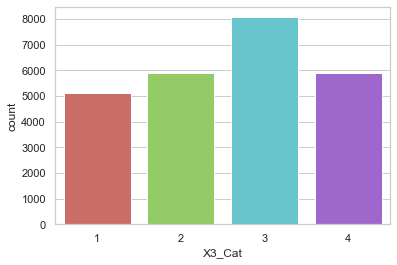

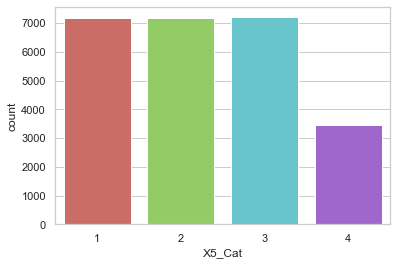

In [10]:
## Visualizing data across our New categorical Age-group and Credit Scoring groups.
sb.countplot(x='X3_Cat',data=df1,palette='hls')
plt.show()
sb.countplot(x='X5_Cat',data=df1,palette='hls')
plt.show()


For X3_Cat categorical variable, more observations fall in category 3 than 1, 2 and 4. This means, for variable X3 more customers tend to fall in the range **[45-65]** . For X5_Range categorical variable, categories 1, 2 and 3 have almost same number of observations. Category 4 - range [800,850] has almost half the number of observations. This means, few customers would fall in the range [800,850] for x5 variable and we would expect very low defaults for these customers.

Text(0, 0.5, 'Frequency')

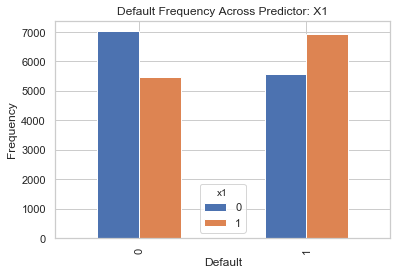

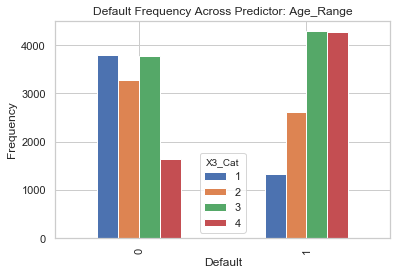

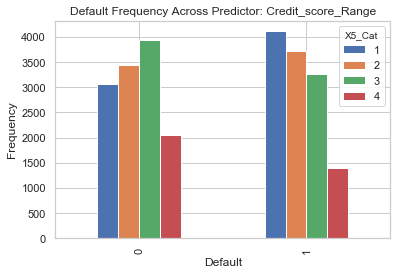

In [11]:
## Visulizing 2 way plots - Dependant Variable Y with other categorical Predictors - X1, X3, X5
pd.crosstab(df1.y,df1.x1).plot(kind='bar')
plt.title('Default Frequency Across Predictor: X1')
plt.xlabel('Default')
plt.ylabel('Frequency')

pd.crosstab(df1.y,df1.X3_Cat).plot(kind='bar')
plt.title('Default Frequency Across Predictor: Age_Range')
plt.xlabel('Default')
plt.ylabel('Frequency')

pd.crosstab(df1.y,df1.X5_Cat).plot(kind='bar')
plt.title('Default Frequency Across Predictor: Credit_score_Range')
plt.xlabel('Default')
plt.ylabel('Frequency')

The barplots above show frequency for each class of Y within each category of variables x1, x3 and x5. Overall the plots suggest that there are differences between the categories of x varibles for classes of Y. 

As seen from the above barplots too, Category4 in X5_Cat has the least defaults across all categories.
Similarly, Category4 in X3_cat has the highest defaults across all other categories.

### **Boxplots** 

-- provide a good visual Representation of our data across the Output Variable and helps us to identify patterns in our data.


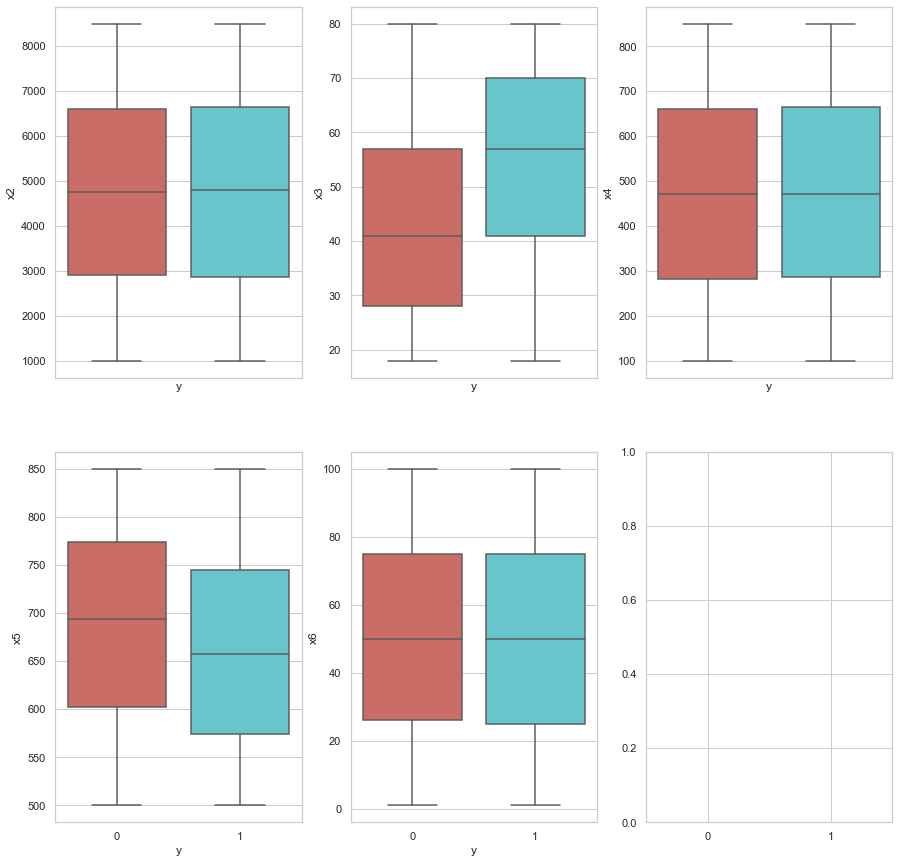

In [12]:
## Boxplots provide a good visual Representation of our data across the Output Variable and helps us to identify patterns in our data.

f, axes = plt.subplots(2,3, figsize=(15, 15), sharex=True)
sb.boxplot(x='y', y='x2', data=df1, palette='hls',ax=axes[0, 0])
#plt.show()
sb.boxplot(x='y', y='x3', data=df1, palette='hls',ax=axes[0, 1])
#plt.show()
sb.boxplot(x='y', y='x4', data=df1, palette='hls',ax=axes[0, 2])
#plt.show()
sb.boxplot(x='y', y='x5', data=df1, palette='hls',ax=axes[1, 0])
#plt.show()
sb.boxplot(x='y', y='x6', data=df1, palette='hls',ax=axes[1, 1])


Variable X3 and X5 show a visible trend across out output variable. 
Means across defaulted obligors and Non-defaults are different in variable X3 and X5 suggesting they are potentially good predictors for our Output variable Y.


### **Histograms**

-- provide a good way to visualise the distribution of our data.
Since we are interested in classification, we can look at distribution of each predictor varaible across our Output classes.
This helps in identifying underlying patterns which we can explore in our model.


------ Histogram X2 across Y-Categories------


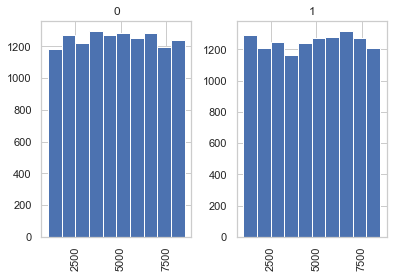

------ Histogram X3 across Y-Categories ------


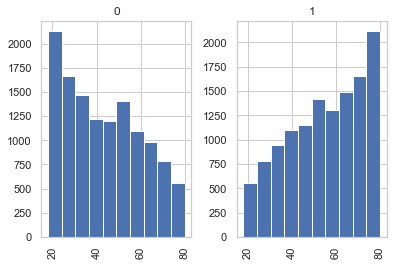

------ Histogram X4 across Y-Categories ------


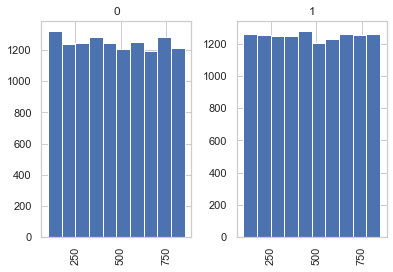

------ Histogram X5 across Y-Categories ------


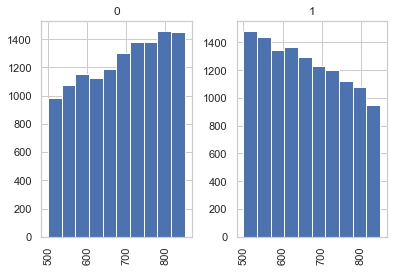

------ Histogram X6 across Y-Categories ------


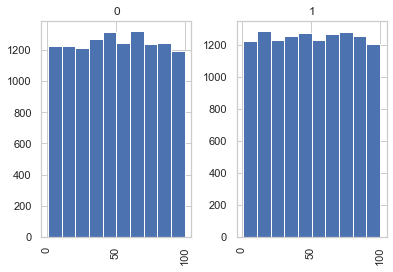

In [13]:

print("------ Histogram X2 across Y-Categories------")
df1['x2'].hist(by=df1['y'])
plt.show()

print("------ Histogram X3 across Y-Categories ------")

df1['x3'].hist(by=df1['y'])
plt.show()

print("------ Histogram X4 across Y-Categories ------")
df1['x4'].hist(by=df1['y'])
plt.show()

print("------ Histogram X5 across Y-Categories ------")
df1['x5'].hist(by=df1['y'])
plt.show()

print("------ Histogram X6 across Y-Categories ------")
df1['x6'].hist(by=df1['y'])
plt.show()


#### **Inference from Histogram**

Variable X3 has an upward trend - As X3 increases , the Number of defaults tend to increase.

Variable X5 has an Downward trend - As X5 increases , the Number of defaults tend to decrease.


## Model Building

### Initial Model - Logistic Regression.
#### Since its a classification Model, we can try out different modeling approaches like Logistic Regression, Random Forest, Support Vector Machines(SVM) and Bayesian Modeling. Looking at simplicity, ease of implementation and interpretability - We will work with Binary Logistic Regression 


In [14]:
## Logistic Regression Data Prep. 
X=df1.loc[:, df1.columns != "y"]
y=df1.loc[:, df1.columns == "y"]
predictor_x_cols=['x1', 'x2', 'x3', 'x4', 'x5', 'x6']

In [15]:
# Split the data into training and testing sets. We will use 60% for training and 40% for Testing.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)


In [16]:
## Scaling the data before the model fit.

sc_X = StandardScaler()
X_train2 = pd.DataFrame(sc_X.fit_transform(X_train))
X_test2 = pd.DataFrame(sc_X.transform(X_test))
X_train2.columns = X_train.columns.values
X_test2.columns = X_test.columns.values
X_train2.index = X_train.index.values
X_test2.index = X_test.index.values
X_train = X_train2
X_test = X_test2

In [17]:
## Add A constant since Logistic regression in statsmodel requires a constant to be specified explicitly.
X_train=sm.add_constant(X_train)
X_test=sm.add_constant(X_test)


/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [18]:
## Train initial Model on all Variables.
cols1=['const', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6']
model1 = sm.Logit(y_train, X_train[cols1])

result = model1.fit()
print(result.params)

## Get Probability of Default PD
predictions_prob=result.predict(X_train[cols1])

## Get Class labels 0,1 
X_predictions=(result.predict(X_train[cols1]) >= 0.5).astype(int)
y_predictions=(result.predict(X_test[cols1]) >= 0.5).astype(int)
print(result.pred_table())
print(result.summary())

### Train Set
print(classification_report(y_train, X_predictions))

### Test Set
print(classification_report(y_test, y_predictions))


Optimization terminated successfully.
         Current function value: 0.623230
         Iterations 5
const    0.011888
x1       0.279651
x2       0.002065
x3       0.709258
x4      -0.023118
x5      -0.298272
x6      -0.005897
dtype: float64
[[4682. 2776.]
 [2751. 4791.]]
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                15000
Model:                          Logit   Df Residuals:                    14993
Method:                           MLE   Df Model:                            6
Date:                Mon, 14 Dec 2020   Pseudo R-squ.:                  0.1008
Time:                        14:56:43   Log-Likelihood:                -9348.4
converged:                       True   LL-Null:                       -10397.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------

Get **Model results** and **Average Marginal Effects** for each predictor Variable:

In [19]:
# Fetching the statistics
stat_df=pd.DataFrame({'coefficients':result.params, 'p-value': result.pvalues, 'odds_ratio': np.exp(result.params)})
# Condition for significant parameters
significant_params=stat_df[stat_df['p-value']<=0.05].index
#significant_params= significant_params.drop('const')
print(significant_params)

print('Total number of parameters: %s '%len(X_train[cols1].keys()) )
print('Number of Significant Parameters: %s'%(len(significant_params)))
print('--- Odds Ratio of the predictors in our model ---')
stat_df.loc[significant_params].sort_values('odds_ratio', ascending=False)['odds_ratio']

Index(['x1', 'x3', 'x5'], dtype='object')
Total number of parameters: 7 
Number of Significant Parameters: 3
--- Odds Ratio of the predictors in our model ---


x3    2.032483
x1    1.322668
x5    0.742100
Name: odds_ratio, dtype: float64

In [20]:
AME=result.get_margeff(at='overall',method='dydx')
AME.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:                      y
Method:                          dydx
At:                           overall
==============================================================================
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0606      0.004     16.342      0.000       0.053       0.068
x2             0.0004      0.004      0.118      0.906      -0.007       0.008
x3             0.1537      0.003     48.128      0.000       0.147       0.160
x4            -0.0050      0.004     -1.319      0.187      -0.012       0.002
x5            -0.0646      0.004    -17.418      0.000      -0.072      -0.057
x6            -0.0013      0.004     -0.336      0.737      -0.009       0.006
==============================================================================
"""

------------------------------------------------------------------------------------------------------------------------------------

**Inferences:**

The output of logistic regression provides us with a lot of information. 
Firstly we can identify the variables which are statistically insignificant in predicting the output variable.
This helpd us in feature selection and limiting our model with fewer but best predictors in our model.

From the initial model , Variables X1,X3 and X5 are statistically significant as their p-value <0.05. We can try a model with just 3 variables and arrive at good estimates.

The model accuracy is around 0.63 with all variables.

Marginal effects is a good metric to understand the impact of a predictor on the Outcome variable. It measures the change in outcome as a function of change in predictor variable while keeping others constant

The interpretation of Average Marginal Effects is similar to linear models. 
1. AME  - X1 - 0.0606 - unit increase in X1 increases Probability of default by 6.06% 
2. AME  - X3 - 0.1537 - unit increase in X3 increases Probability of default by 15.37% 
3. AME  - X5 - -0.0646 - unit increase in X5 decreases Probability of default by 6.46% 
4. AME  - X2, X4, X6 have very less impact on the Model's predictive power. they have <0.05% impact on PD for each unit increase.  



------------------------------------------------------------------------------------------------------------------------------------

### Model 2: Using Categorical X3 and X5. 


In [21]:
# Building a Model using categorical X3 and X5 variables and checking accuracy.

df2=df1.copy()
df2=pd.get_dummies(df2, columns=['X3_Cat'], prefix = ['X3_Cat_'])
df2 = pd.get_dummies(df2, columns=['X5_Cat'], prefix = ['X5_Cat_'])
df2.head()
X=df2.loc[:, df2.columns != "y"]
y=df2.loc[:, df2.columns == "y"]
# Split the data into training and testing sets. We will use 60% for training and 40% for Testing.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
X_train=sm.add_constant(X_train)
X_test=sm.add_constant(X_test)
cols2_cat=['const', 'x1', 'x2', 'x4','x6','X3_Cat__2','X3_Cat__3','X3_Cat__4','X5_Cat__2','X5_Cat__3','X5_Cat__4']
model2_cat = sm.Logit(y_train, X_train[cols2_cat])
result_cat = model2_cat.fit()
print(result_cat.params)

## Get Probability of Default PD
predictions_prob=result_cat.predict(X_train[cols2_cat])

## Get Class labels 0,1 
X_predictions=(result_cat.predict(X_train[cols2_cat]) >= 0.5).astype(int)
y_predictions=(result_cat.predict(X_test[cols2_cat]) >= 0.5).astype(int)
print(result_cat.pred_table())
print(result_cat.summary())

### Train Set
print(classification_report(y_train, X_predictions))

### Test Set
print(classification_report(y_test, y_predictions))
AME=result_cat.get_margeff(at='overall',method='dydx')
AME.summary()

Optimization terminated successfully.
         Current function value: 0.627200
         Iterations 5
const       -9.338236e-01
x1           5.518784e-01
x2           5.575754e-07
x4          -1.027515e-04
x6          -2.844368e-04
X3_Cat__2    8.700806e-01
X3_Cat__3    1.227678e+00
X3_Cat__4    2.060955e+00
X5_Cat__2   -2.979616e-01
X5_Cat__3   -6.183721e-01
X5_Cat__4   -7.424939e-01
dtype: float64
[[4565. 2893.]
 [2720. 4822.]]
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                15000
Model:                          Logit   Df Residuals:                    14989
Method:                           MLE   Df Model:                           10
Date:                Mon, 14 Dec 2020   Pseudo R-squ.:                 0.09512
Time:                        14:57:57   Log-Likelihood:                -9408.0
converged:                       True   LL-Null:                       -10397.
Covariance Ty

<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:                      y
Method:                          dydx
At:                           overall
==============================================================================
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1207      0.007     16.203      0.000       0.106       0.135
x2          1.219e-07   1.77e-06      0.069      0.945   -3.35e-06    3.59e-06
x4         -2.247e-05   1.76e-05     -1.276      0.202    -5.7e-05     1.2e-05
x6          -6.22e-05      0.000     -0.466      0.641      -0.000       0.000
X3_Cat__2      0.1903      0.012     16.536      0.000       0.168       0.213
X3_Cat__3      0.2685      0.010     25.833      0.000       0.248       0.289
X3_Cat__4      0.4507      0.010     43.931      0.000       0.431       0.471
X5_Cat__2     -0.0652      0.010     -6.519      0.000      -0.085      -0.046
X5_Cat__3     -0.1352      0.010    -13.635      0.000      -0.155      -0.116
X5_Cat__4     -0.1624      0.012    -13.106      0.000      -0.187      -0.138
==============================================================================
"""


------------------------------------------------------------------------------------------------------------------------------------

### Review:

The outputs from using **Categorical** **X3** and **X5** in the model are pretty similar to using **Numerical** values of **X3** and **X5**.
The model accuracy hasnt changed significantly and thus categorical inputs have no significant advantage over using numeric values for these variables.
For ease of use and implementation, We can stick to our original data fields and build a model using numeric data.

------------------------------------------------------------------------------------------------------------------------------------


## Feature Selection

Two methods which can help in selecting the best features for our model:
1. Recursive Feature Elimination.
2. Feature importance from Random Forest.

In [22]:
## Recursive Feature Elimination - Selecting top predictors.

logreg = LogisticRegression()
rfe = RFE(logreg, 3)
rfe = rfe.fit(X_train[cols1], y_train)
print(cols1)
print(rfe.support_)
print(rfe.ranking_)

pd.DataFrame({'Predictors':np.array(cols1), 'RFE_Support':rfe.support_,'RFE_Rank':rfe.ranking_})


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['const', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6']
[ True  True False  True False False False]
[1 1 5 1 4 2 3]


,Predictors,RFE_Support,RFE_Rank
0,const,True,1
1,x1,True,1
2,x2,False,5
3,x3,True,1
4,x4,False,4
5,x5,False,2
6,x6,False,3


### Review:

RFE results selectes X1, X3 and X5 as the best 3 feature model for our classification.

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
No handles with labels found to put in legend.


x3    0.235169
x5    0.196423
x2    0.196021
x4    0.187650
x6    0.165695
x1    0.019043
dtype: float64


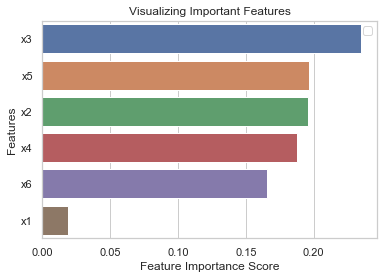

In [23]:
## Random Forest for Feature Importance - Help us in feature selection.

X_rf=loan_application.loc[:, loan_application.columns != "y"]
y_rf=loan_application.loc[:, loan_application.columns == "y"]
# Split dataset into training set and test set
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size=0.3) # 70% training and 30% test
#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100,bootstrap=True,max_features='sqrt')
#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train_rf,y_train_rf)
y_pred=clf.predict(X_test_rf)
## Feature Importance
feature_imp = pd.Series(clf.feature_importances_,index=['x1', 'x2', 'x3', 'x4', 'x5', 'x6']).sort_values(ascending=False)
print(feature_imp)

%matplotlib inline
# Creating a bar plot
sb.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()



### Review:

Variables X3 and X5 have the highest Variable Importances as seen from the Random Forest Model.
This is an interesting finding as both our feature selection models outputs variables X3 and X5 as the top predictors.
Since Variable X1 was significant in our first model, We can try to build a smaller and more accurate model using just 3 variables.


------------------------------------------------------------------------------------------------------------------------------------
# Final Model


- From Our Visual analysis and information obtained from Feature selection approaches above; we can use 3 variables in our final Model -- X1, X3 and X5.

------------------------------------------------------------------------------------------------------------------------------------

Optimization terminated successfully.
         Current function value: 0.623383
         Iterations 5
Coefficient Values- Log-Odds 
 x1    0.550929
x3    0.038821
x5   -0.003217
dtype: float64
-----------------------------------------------------
ODDS Ratio 
 x1    1.734864
x3    1.039584
x5    0.996788
dtype: float64
-----------------------------------------------------
[[4656. 2802.]
 [2726. 4816.]]
-----------------------------------------------------
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                15000
Model:                          Logit   Df Residuals:                    14997
Method:                           MLE   Df Model:                            2
Date:                Mon, 14 Dec 2020   Pseudo R-squ.:                  0.1006
Time:                        15:02:37   Log-Likelihood:                -9350.7
converged:                       True   LL-Null:                   

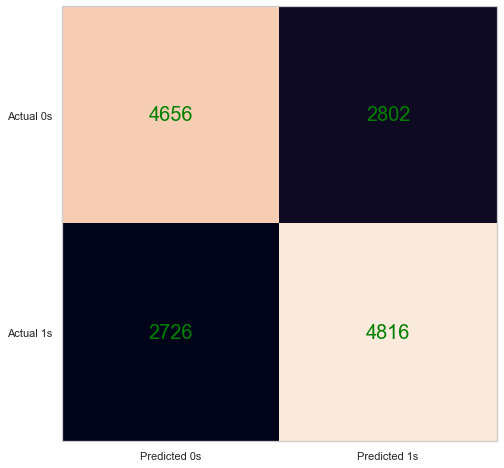

-------- Test Set Confusion Matrix -----------


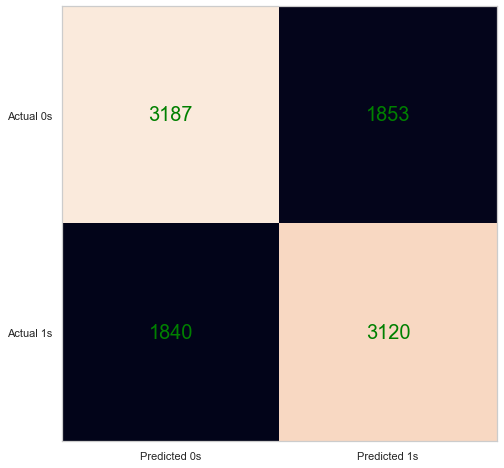

In [25]:
## Final Model after feature selection using above approaches- - Model with X1,x3,x5

X=loan_application.loc[:, loan_application.columns != "y"]
y=loan_application.loc[:, loan_application.columns == "y"]
# Split the data into training and testing sets. We will use 60% for training and 40% for Testing.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
X_train=sm.add_constant(X_train)
X_test=sm.add_constant(X_test)
model2 = sm.Logit(y_train, X_train[["x1","x3","x5"]])
result_final = model2.fit()
print("Coefficient Values- Log-Odds \n",result_final.params)

print("-----------------------------------------------------")

print("ODDS Ratio \n",np.exp(result_final.params))

print("-----------------------------------------------------")

predictions_X_train=result_final.predict(X_train[["x1","x3","x5"]])
predictions_X_test=result_final.predict(X_test[["x1","x3","x5"]])

X_predictions=(result_final.predict(X_train[["x1","x3","x5"]]) >= 0.5).astype(int)
y_predictions=(result_final.predict(X_test[["x1","x3","x5"]]) >= 0.5).astype(int)


print(result_final.pred_table())
print("-----------------------------------------------------")

print(result_final.summary())
print("-----------------------------------------------------")

### Train Set
print(classification_report(y_train, X_predictions))

print("-----------------------------------------------------")

### Test Set
print(classification_report(y_test, y_predictions))



print("-------- Train Set Confusion Matrix -----------")
### Confusion Matrix Plot
cm = confusion_matrix(y_train, X_predictions)
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='Green',size=20)
plt.show()


print("-------- Test Set Confusion Matrix -----------")
### Confusion Matrix Plot
cm = confusion_matrix(y_test, y_predictions)
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='Green',size=20)
plt.show()


**Coefficients:**

Interpretation: Each unit increase in variable increases/decreases the log oddds of PD by coefficient's Value.
- x1    0.550929
- x3    0.038821
- x5   -0.003217

Inference:
- We would Expect 0.550929 Increase in the log-Odds of a Default(y=1) if X1 increases by 1 unit.
- We would Expect 0.038821 Increase in the log-Odds of a Default(y=1) if X3 increases by 1 unit.
- We would Expect -0.003217 Increase in the log-Odds of a Default(y=1) if X5 increases by 1 unit.

The estimated coefficients are the log odds. A better way to interpret the coefficients is by exponentiating the value to obtain ODDs ratio.

**ODDS Ratio** 
- x1    1.734864
- x3    1.039584
- x5    0.996788

X1 and X3 are above 1. This means that they have a positive relationship with the Output Variable.
X5 has a negative relationship with the Output Variable.

Inference:

- We would Expect 73% Increase in the Odds of a Default(y=1) if X1 increases by 1 unit.
- We would Expect 3.9% Increase in the Odds of a Default(y=1) if X3 increases by 1 unit.
- We would Expect 0.32% Decrease in the Odds of a Default(y=1) if X5 increases by 1 unit.




In [26]:
cv_score = cross_val_score(LogisticRegression(), 
                            X_train[["x1","x3","x5"]], y_train,
                            scoring = 'accuracy',
                            cv = 10,
                            n_jobs = -1,
                            verbose = 1)
print(cv_score)
print("Mean CV Score = ",cv_score.mean())


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[0.63866667 0.63066667 0.63       0.642      0.64266667 0.62666667
 0.62       0.61533333 0.636      0.634     ]
Mean CV Score =  0.6315999999999999


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    1.8s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.8s finished


In [27]:
# Fetching the statistics
stat_df=pd.DataFrame({'coefficients':result_final.params, 'p-value': result_final.pvalues, 'odds_ratio': np.exp(result_final.params)})
# Condition for significant parameters
significant_params=stat_df[stat_df['p-value']<=0.05].index
#significant_params= significant_params.drop('const')
print(significant_params)

print('Total number of parameters: %s '%len(X_train[["x1","x3","x5"]].keys()) )
print('Number of Significant Parameters: %s'%(len(significant_params)))
stat_df.loc[significant_params].sort_values('odds_ratio', ascending=False)['odds_ratio']

Index(['x1', 'x3', 'x5'], dtype='object')
Total number of parameters: 3 
Number of Significant Parameters: 3


x1    1.734864
x3    1.039584
x5    0.996788
Name: odds_ratio, dtype: float64

In [28]:
AME=result_final.get_margeff(at='overall',method='dydx')
AME.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:                      y
Method:                          dydx
At:                           overall
==============================================================================
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1195      0.007     16.240      0.000       0.105       0.134
x3             0.0084      0.000     51.336      0.000       0.008       0.009
x5            -0.0007   1.34e-05    -51.858      0.000      -0.001      -0.001
==============================================================================
"""

**AVERAGE MARGINAL EFFECTS**

The interpretation of Average Marginal Effects is similar to linear models. 
1. AME  - X1 - 0.1195 - unit increase in X1 increases Probability of default by 11.95% 
2. AME  - X3 - 0.1195 - unit increase in X3 increases Probability of default by 0.84% 
3. AME  - X5 - -0.0007 - unit increase in X5 decreases Probability of default by 0.07% 

## Model accuracy and Goodness of FIT - ROC Curve

In [29]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_train, X_predictions))
print("Accuracy:",metrics.accuracy_score(y_test, y_predictions))


Accuracy: 0.6314666666666666
Accuracy: 0.6307


In [30]:
## ROC AUC Score
roc_value_train=roc_auc_score(y_train, predictions_X_train)
roc_value_test=roc_auc_score(y_test, predictions_X_test)
print("Training_ROC_AUC_score=",roc_value_train)
print("Testing_ROC_AUC_score=",roc_value_test)

Training_ROC_AUC_score= 0.7028976873159185
Testing_ROC_AUC_score= 0.7060680083525346


## MODEL FIT AND ACCURACY.

Training and Test accuracy are at 63% which is acceptable for our Binary classification Problem.

The Model fits the Data well in Training and Testing sets with a AUC value of 70%.

Our model has good robustness in prediction accuracy as seen from the 10-Fold Cross-Validation results above.

The mean CV Score is 0.6315999999999999


This helps us in being confident in implementing our Model for New data and would work well. 
We can say our model predicts 63% of the time accurate results and can be confident in implementing our model.

No handles with labels found to put in legend.


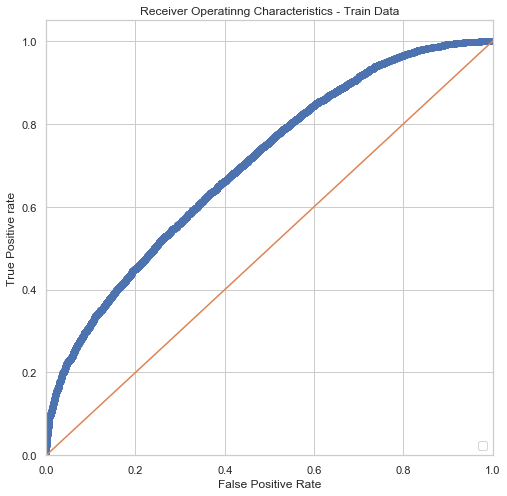

No handles with labels found to put in legend.


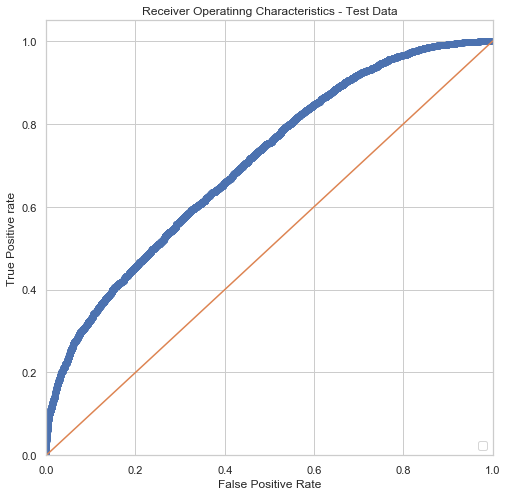

In [31]:
## ROC Curve for Test Set. -- Out of Sample Accuracy.
fpr, tpr, thresholds = roc_curve(y_train, predictions_X_train)
# To get roc stats in df
roc_df=pd.DataFrame({'thresholds': thresholds,'tpr':tpr,'fpr':fpr})

# Plotting the ROC curve
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr,marker="o")
plt.plot([0,1],[0,1])
plt.xlim(0,1)
plt.ylim(0,1.05)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive rate")
plt.title("Receiver Operatinng Characteristics - Train Data")
plt.legend(loc="lower right")
plt.show()

## ROC Curve for Test Set. -- Out of Sample Accuracy.
fpr, tpr, thresholds = roc_curve(y_test, predictions_X_test)
# To get roc stats in df
roc_df=pd.DataFrame({'thresholds': thresholds,'tpr':tpr,'fpr':fpr})

# Plotting the ROC curve
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr,marker="o")
plt.plot([0,1],[0,1])
plt.xlim(0,1)
plt.ylim(0,1.05)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive rate")
plt.title("Receiver Operatinng Characteristics - Test Data")
plt.legend(loc="lower right")
plt.show()


## OUTPUT RESULTS TO CSV

In [32]:

X_train["PD"]=predictions_X_train
X_train["Default"]=X_predictions
X_test["PD"]=predictions_X_test
X_test["Default"]=y_predictions


In [33]:
Train_data=pd.concat([X_train,y_train],axis=1)
Test_data=pd.concat([X_test,y_test],axis=1)

In [34]:
Output_df=pd.concat([Train_data,Test_data],axis=0).sort_index()


In [35]:
Output_df

,const,x1,x2,x3,x4,x5,x6,PD,Default,y
0,1.0,0,2508,54,231,745,2,0.425523,0,1
1,1.0,1,1854,61,504,746,79,0.626989,1,1
2,1.0,0,3038,39,126,610,81,0.389790,0,1
3,1.0,0,6889,25,719,693,68,0.221202,0,0
4,1.0,1,5785,72,189,805,27,0.680607,1,1
...,...,...,...,...,...,...,...,...,...,...
24995,1.0,1,7929,45,123,548,95,0.630671,1,0
24996,1.0,0,5428,38,269,566,92,0.414479,0,0
24997,1.0,1,3051,21,839,600,11,0.362652,0,0
24998,1.0,0,2917,64,169,526,26,0.688375,1,0


In [36]:
Output_df.to_csv("Result_PD.csv")